In [24]:
import uproot
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import minimize
from skimage.feature import peak_local_max

In [2]:
plt.rcParams['figure.dpi'] = 400
plt.style.use('fivethirtyeight')

In [3]:
filename = "/home/user/geant_projects/photosensors_mt/build/Output/output0.root"
file = uproot.open(filename)

names = np.array(file.keys())
times = names[:len(names) // 3]
cover_hists = names[len(names) // 3::2]

In [4]:
digit_pattern = "-?\d+\.?\d*"

In [5]:
def GetCarpetSignal(hist):
    return hist[hist.shape[0] // 2 - 10:hist.shape[0] // 2 + 10, hist.shape[0] // 2 - 10:hist.shape[0] // 2 + 10]

In [6]:
def VEM(hist):
    filt = (hist < 0.5)
    hist[filt] = 0.001
    hist = (1 + np.log(hist/8)/np.log(1.12)) // 1
    hist[hist < 0] = 0
    #hist[filt] = -1

    return hist

In [7]:
n = 3

In [8]:
x_det = np.arange(-6.65, 6.66, 0.7)
y_det = np.flip(np.arange(-6.65, 6.66, 0.7))

carpet_coords = np.zeros((len(x_det), len(y_det), 2))

for i in range(len(y_det)):
    for j in range(len(x_det)):
        carpet_coords[i][j] = np.array([x_det[j], y_det[i]])

In [9]:
def tree_length(params, carpet_signal):

    tree_length = 0
    
    x0, y0 = params

    r = np.sqrt((carpet_coords[:, :, 0] - x0)**2 + (carpet_coords[:, :, 1] - y0)**2)
    
    for i in range(carpet_signal.shape[1]):
        for j in range(carpet_signal.shape[0]):
        
            branch_len = (carpet_signal[i][j]**n)*r[i][j]

            tree_length += branch_len
        
    return tree_length

In [10]:
def find_best_xy(carpet_signal):
    
    true_coord = np.array([-6.65, 6.65])
    true_len = tree_length(true_coord, carpet_signal)

    for coord_row in carpet_coords:
        for coord in coord_row:
            length = tree_length(coord, carpet_signal)
            if (length < true_len):
                true_len = length
                true_coord = coord

    return true_coord

In [11]:
def xy_constr(params):
    x0, y0 = params

    return 40 - np.sqrt(x0**2+y0**2)

In [12]:
xy_constraint = {'type': 'ineq', 'fun': xy_constr}

def get_xy(signal):

    sig = VEM(signal)

    xy_guess = find_best_xy(sig)

    #result = minimize(tree_length, xy_guess, method = 'SLSQP', constraints=xy_constraint, args=signal, tol=1e-6)
    result = minimize(tree_length, xy_guess, method = 'Nelder-Mead', args=sig, tol=1e-6)

    return result

In [13]:
cover_signals = np.zeros((len(cover_hists), 20, 20))

for i, hist in enumerate(cover_hists):
    cov_hist = np.copy(np.flip(file[hist].values().T, 0))
    cover_signals[i] = GetCarpetSignal(cov_hist)

# Поиск локального максимума

In [29]:
def neighbors(matrix, rowNumber, colNumber):
    result = []
    for rowAdd in range(-1, 2):
        newRow = rowNumber + rowAdd
        if newRow >= 0 and newRow <= len(matrix)-1:
            for colAdd in range(-1, 2):
                newCol = colNumber + colAdd
                if newCol >= 0 and newCol <= len(matrix)-1:
                    if newCol == colNumber and newRow == rowNumber:
                        continue
                    result.append(matrix[newCol][newRow])
    return np.array(result)

In [80]:
def find_smoothest_max(signal, coords):

    if (len(coords) == 0):
        return np.array([0, 0])

    decrease = np.zeros(len(coords))
    
    for i, coordinate in enumerate(coords):

        amplitude = signal[coordinate[0], coordinate[1]]

        neighbours = neighbors(signal, coordinate[1], coordinate[0])

        decrease[i] = np.sum(neighbours) / (len(neighbours))

    smoothest_max_coord = coords[np.argmax(decrease)]

    return smoothest_max_coord

[8 0]


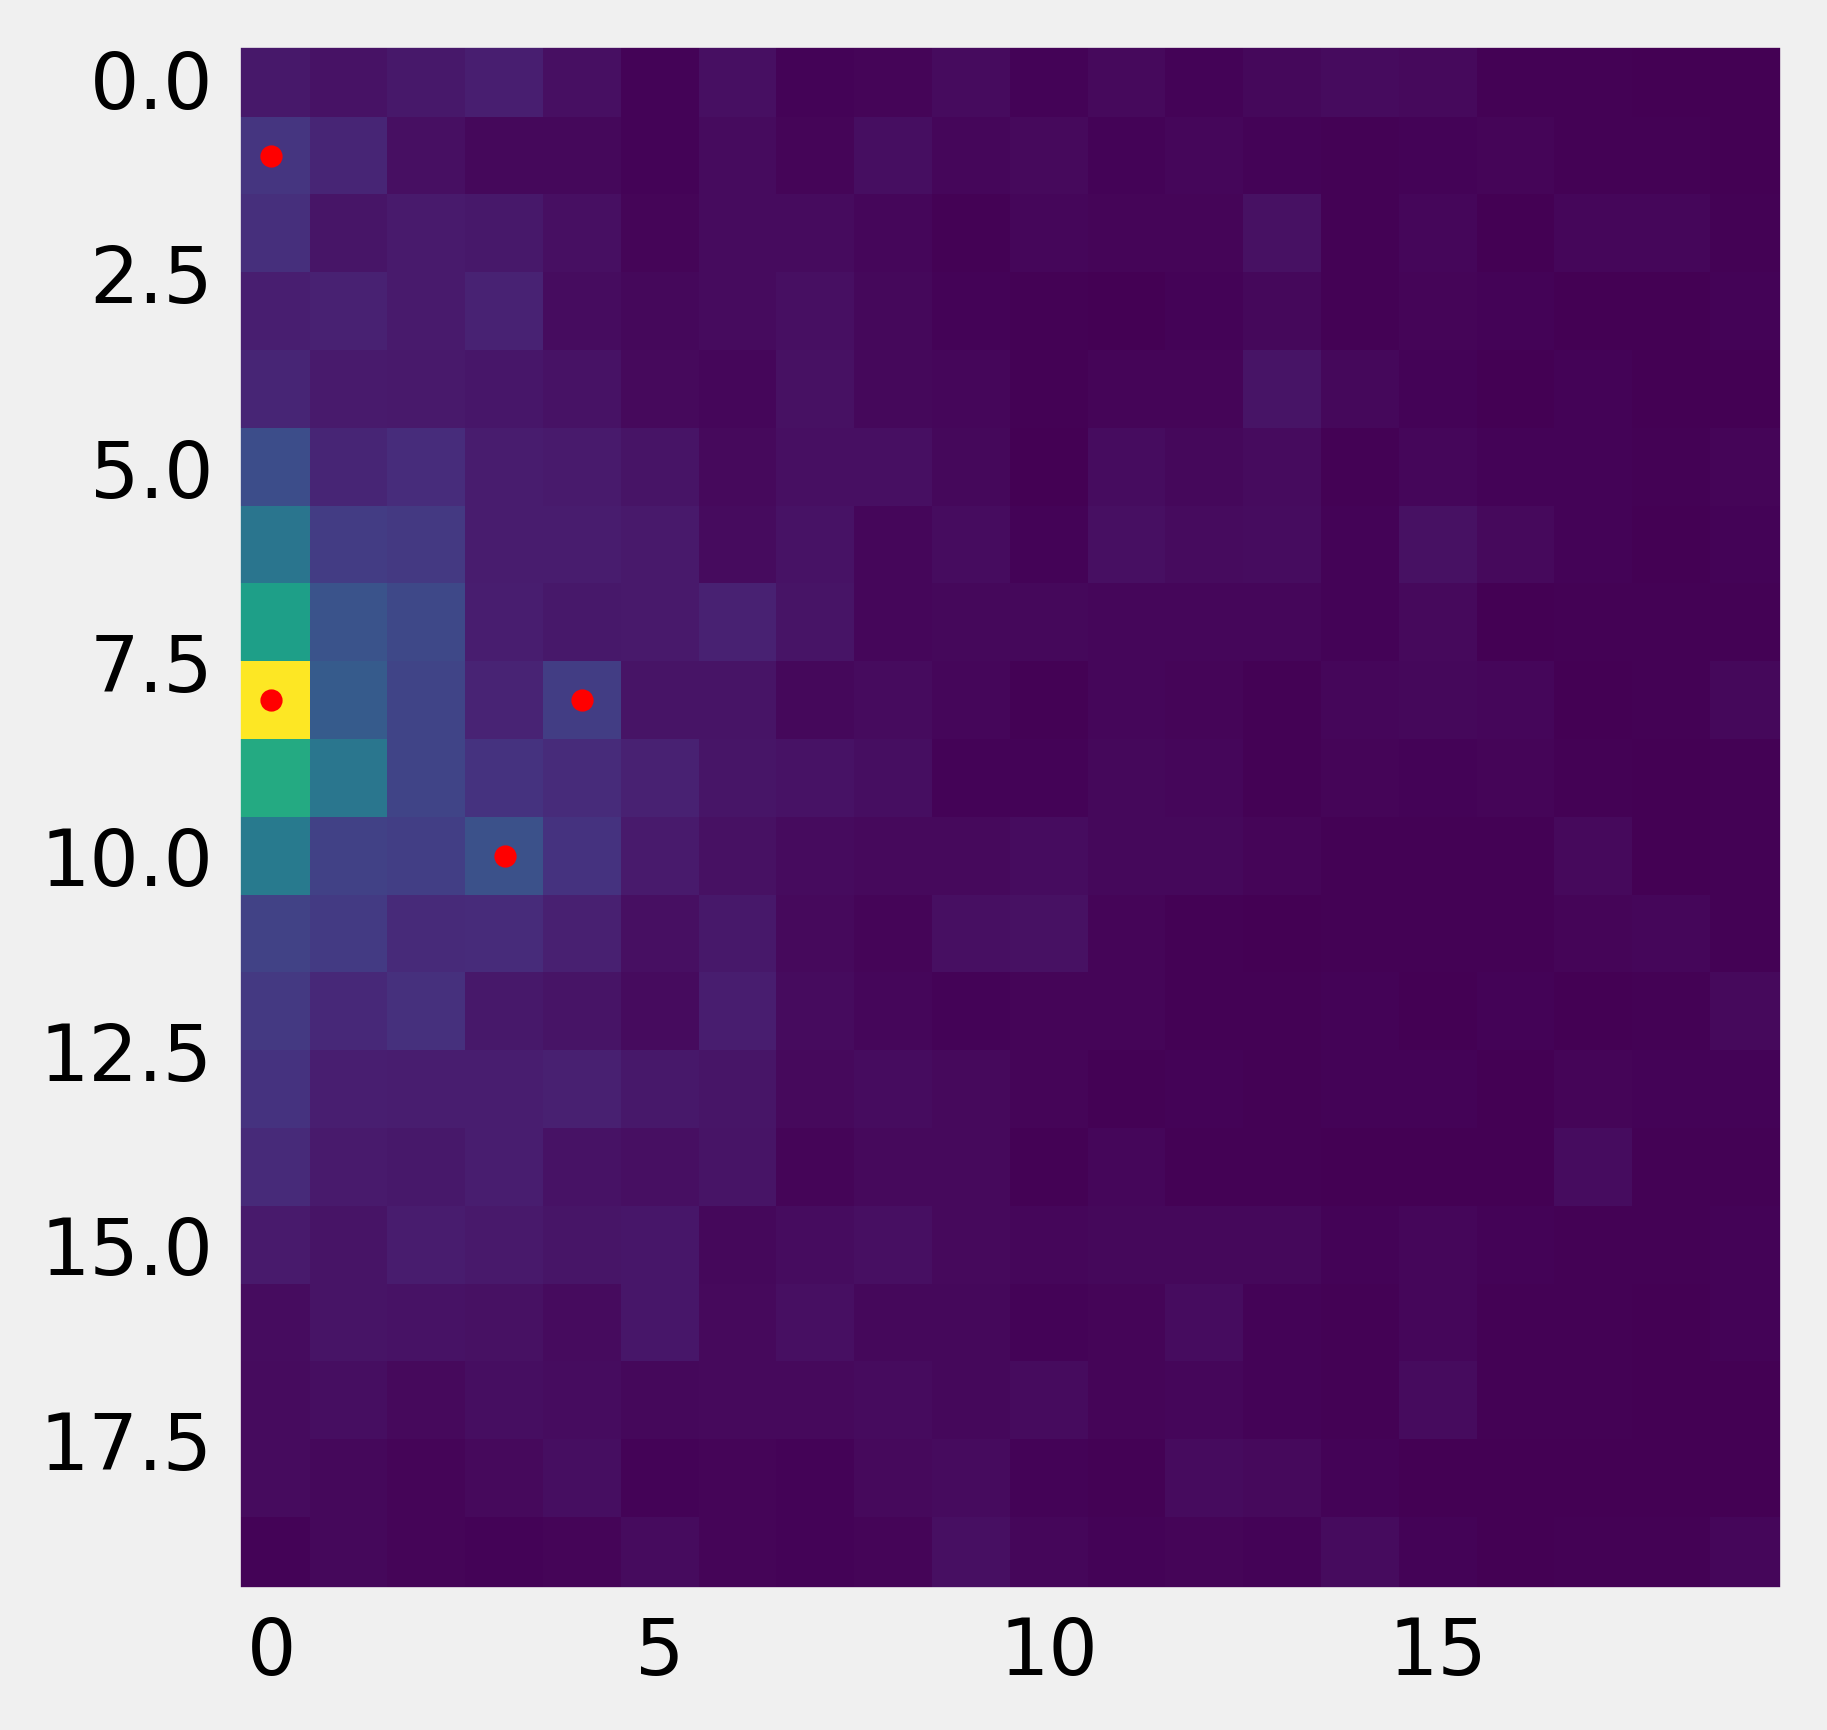

In [81]:
coordinates = peak_local_max(cover_signals[0], exclude_border=False, threshold_rel=0.1)

print(find_smoothest_max(cover_signals[0], coordinates))
# for coordinate in coordinates:
#     print(cover_signals[0][coordinate[0], coordinate[1]])

plt.imshow(cover_signals[0])
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

plt.grid(False)

In [85]:
pdf = PdfPages("100_Showers_reconstruction_local_max_with_error.pdf")

for signal in cover_signals:

    sinal_copy = np.copy(signal)

    ind_x = np.random.randint(0, 20)
    ind_y = np.random.randint(0, 20)

    max_sig = np.max(sinal_copy)

    if max_sig < 100:
        sinal_copy[ind_x][ind_y] += 5*max_sig
    else:
        sinal_copy[ind_x][ind_y] += 500

    sig = VEM(sinal_copy)
    
    plt.imshow(sig, cmap = 'turbo')
    plt.grid(False)
    
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    
    for i in range(sinal_copy.shape[0]):
        for j in range(sinal_copy.shape[1]):
            #plt.text(j, i, round(sig[i, j]), ha="center", va="center", color="w", fontsize=5)
            if ((i == ind_x) & (j == ind_y)):
                plt.text(j, i, round(sig[i, j]), ha="center", va="center", color="r", fontsize=10)
            else:
                plt.text(j, i, round(sig[i, j]), ha="center", va="center", color="w", fontsize=5)
    
    coordinates = peak_local_max(sig, exclude_border=False, threshold_rel=0.1)
    xy = find_smoothest_max(sig, coordinates)
    
    plt.axvline(x=xy[1], linewidth=1, color='r')
    plt.axhline(y=xy[0], linewidth=1, color='r')

    pdf.savefig()
    plt.close()

pdf.close()

# Дерево

In [30]:
pdf = PdfPages("100_Showers_reconstruction_with_error.pdf")

for signal in cover_signals:

    sinal_copy = np.copy(signal)

    ind_x = np.random.randint(0, 20)
    ind_y = np.random.randint(0, 20)

    max_sig = np.max(sinal_copy)

    if max_sig < 100:
        sinal_copy[ind_x][ind_y] += 1.5*max_sig
    else:
        sinal_copy[ind_x][ind_y] += 100

    sig = VEM(sinal_copy)
    
    plt.imshow(sig, cmap = 'turbo')
    plt.grid(False)
    
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    
    for i in range(signal.shape[0]):
        for j in range(signal.shape[1]):
            if ((i == ind_x) & (j == ind_y)):
                plt.text(j, i, round(sig[i, j]), ha="center", va="center", color="r", fontsize=10)
            else:
                plt.text(j, i, round(sig[i, j]), ha="center", va="center", color="w", fontsize=5)
    
    result = get_xy(sinal_copy)
    xy = result.x
    
    i = (6.65-xy[1])/0.7
    j = (xy[0]+6.65)/0.7
    
    plt.axvline(x=j, linewidth=1, color='r')
    plt.axhline(y=i, linewidth=1, color='r')

    pdf.savefig()
    plt.close()

pdf.close()

In [ ]:
err = []

for i, signal in enumerate(cover_signals):
    
    result = get_xy(signal)

    if result.success:
        fitted_params = result.x

        #sig_err = np.sqrt((fitted_params[0] - float(re.findall(digit_pattern, cover_hists[i])[3]))**2 + (fitted_params[1] - float(re.findall(digit_pattern, cover_hists[i])[4]))**2)

        #err.append(sig_err)

        print(fitted_params, 'The true coordinates are ', re.findall(digit_pattern, cover_hists[i])[3], re.findall(digit_pattern, cover_hists[i])[4])
        
#err = np.array(err)

In [14]:
err_mean_array = []

n_diapason = np.arange(1, 10, 0.1)

for n in n_diapason:

    err = []
    
    for i, signal in enumerate(cover_signals):
        
        result = get_xy(signal)
    
        if result.success:
            fitted_params = result.x
    
            sig_err = np.sqrt((fitted_params[0] - float(re.findall(digit_pattern, cover_hists[i])[3]))**2 + (fitted_params[1] - float(re.findall(digit_pattern, cover_hists[i])[4]))**2)
    
            err.append(sig_err)
            
    err = np.array(err)

    err_mean_array.append(err.mean())

    print(n, err.mean())
    
err_mean_array = np.array(err_mean_array)

1.0 2.769140795375061
1.1 2.7315131850536702
1.2000000000000002 2.698634362956848
1.3000000000000003 2.668550053975669
1.4000000000000004 2.6407899527772667
1.5000000000000004 2.6155668215678656
1.6000000000000005 2.5930402007826405
1.7000000000000006 2.577324962654012
1.8000000000000007 2.560506320014411
1.9000000000000008 2.5452710120078597
2.000000000000001 2.5322606186368706
2.100000000000001 2.5221194170295425
2.200000000000001 2.5147940333786907
2.300000000000001 2.5098138128447127
2.4000000000000012 2.508160108140361
2.5000000000000013 2.5014255032512445
2.6000000000000014 2.4940354593858705
2.7000000000000015 2.4871752153609576
2.8000000000000016 2.481140723857851
2.9000000000000017 2.475230703247196
3.0000000000000018 2.4694823571238245
3.100000000000002 2.464645065569046
3.200000000000002 2.4598630063772955
3.300000000000002 2.4539727856982823
3.400000000000002 2.448641264028579
3.500000000000002 2.444024739429995
3.6000000000000023 2.439502115518649
3.7000000000000024 2.4350

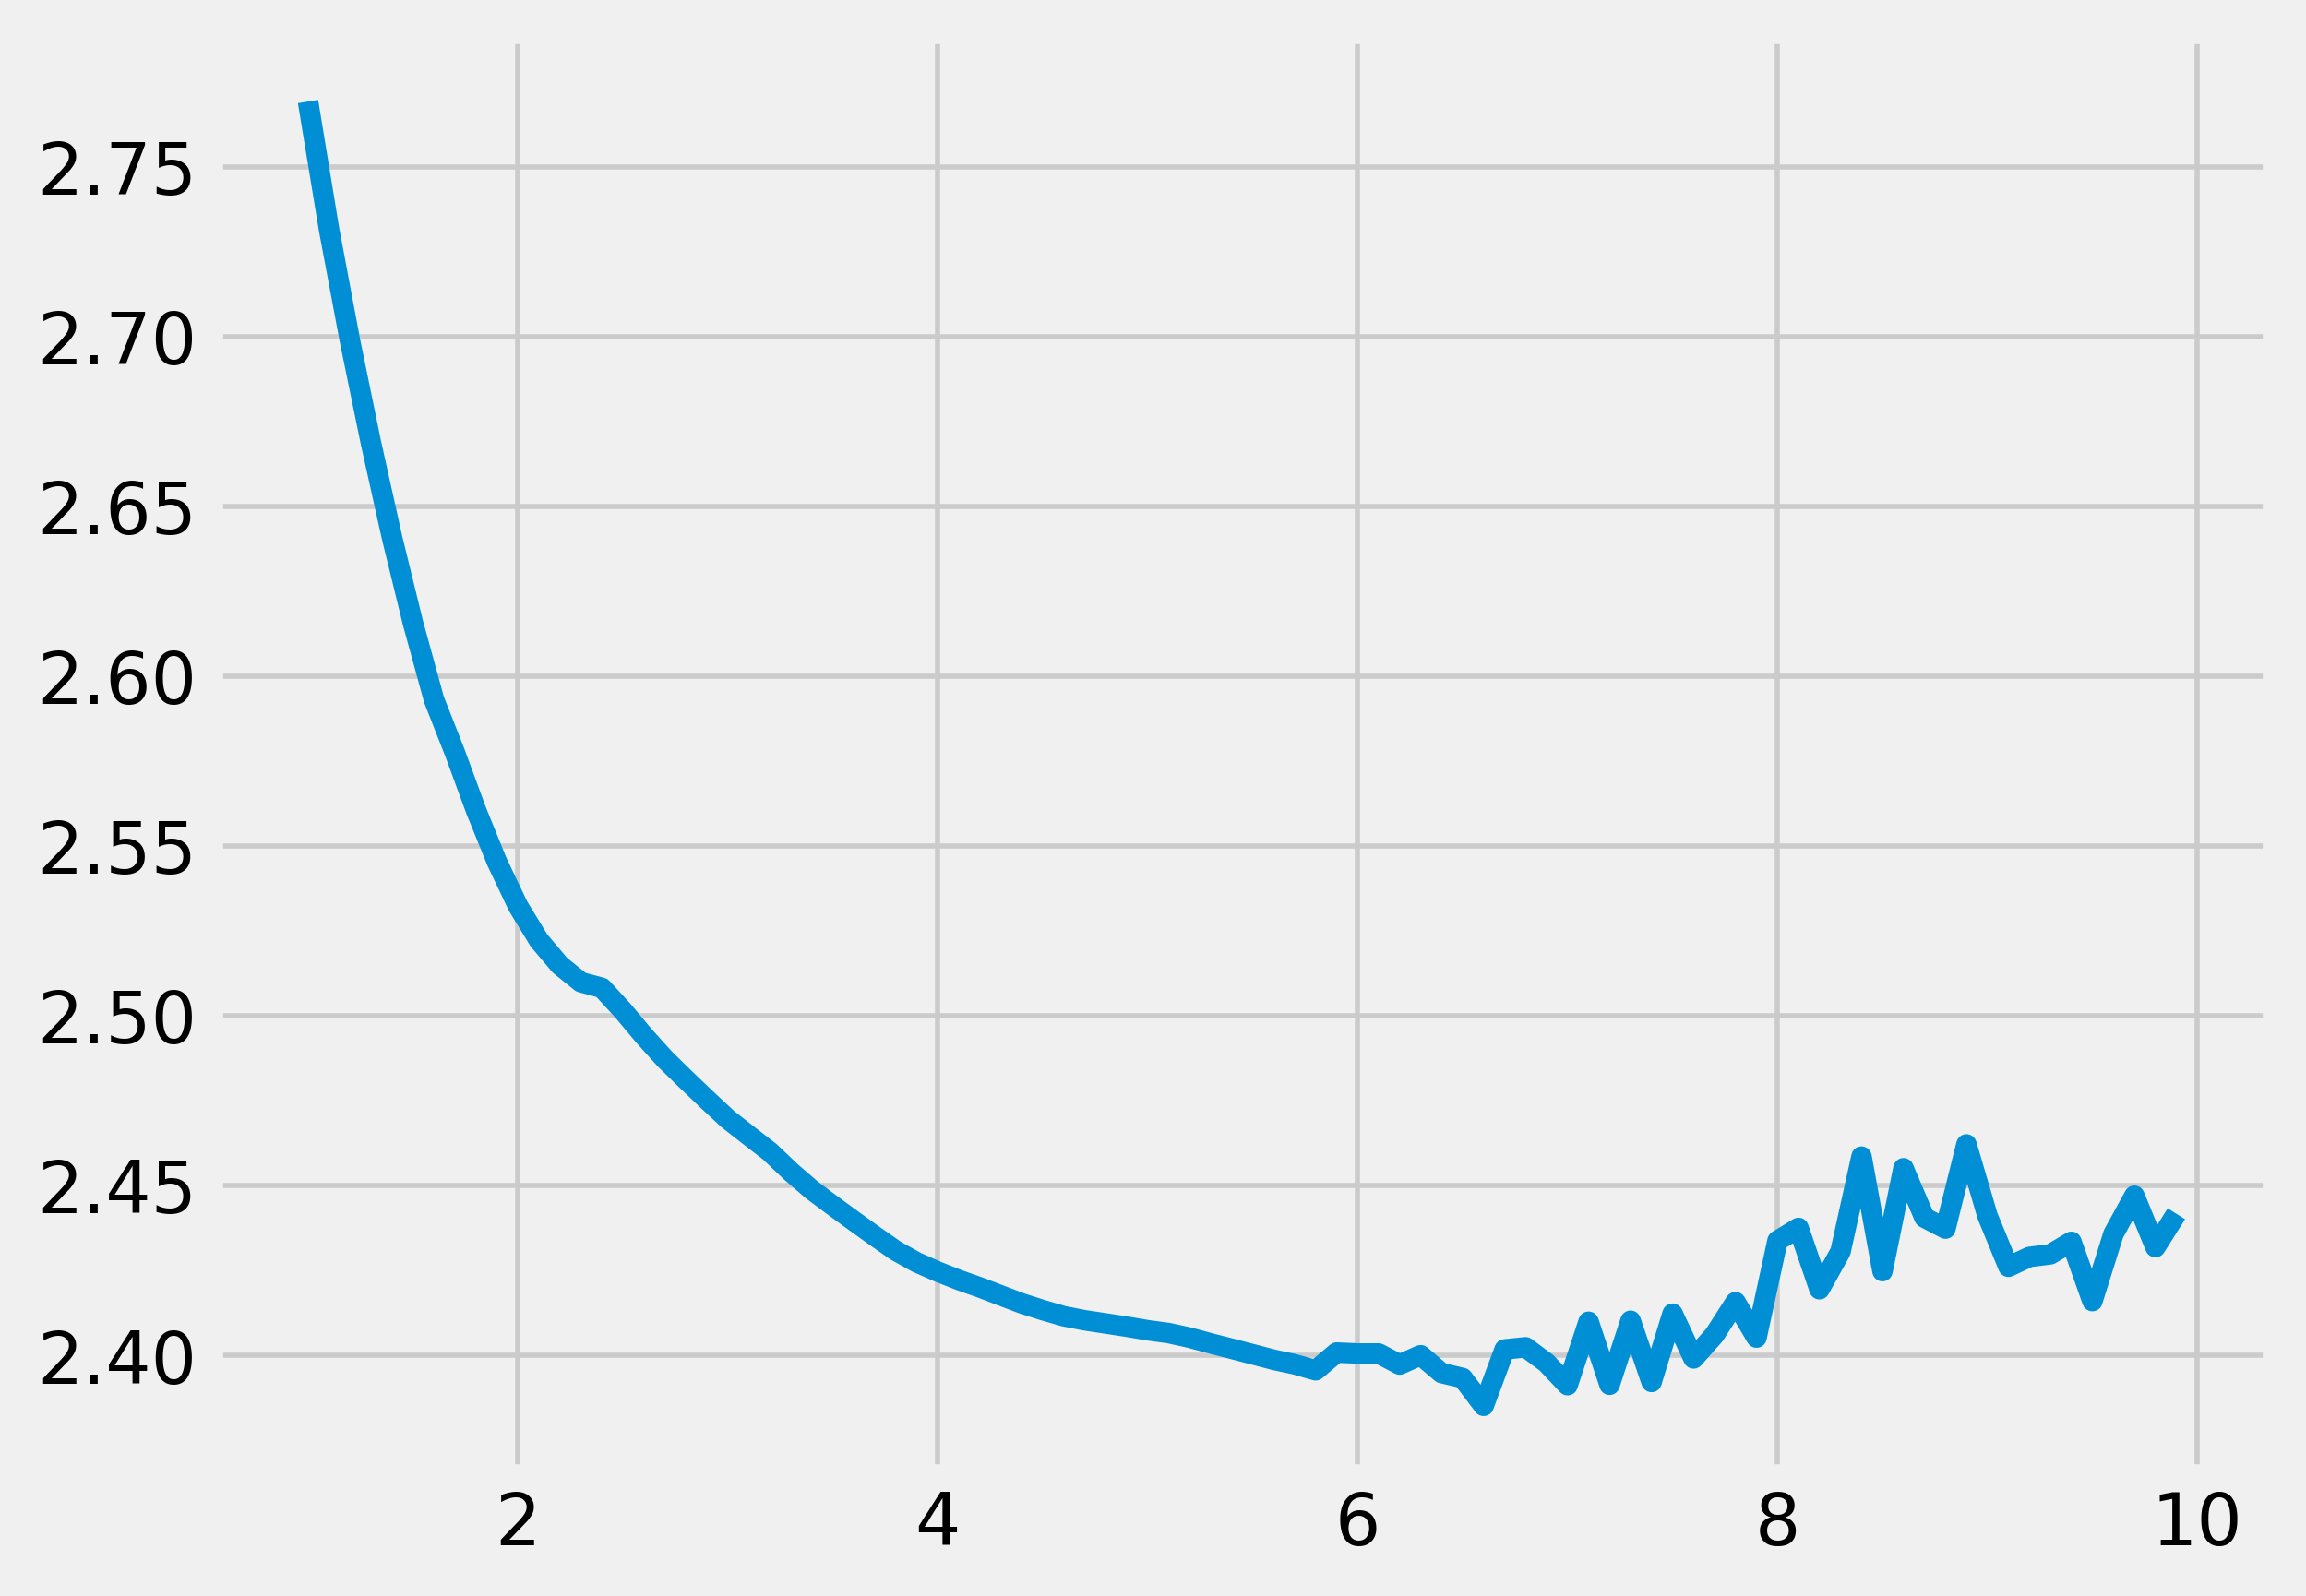

In [16]:
plt.plot(n_diapason, err_mean_array)

# Восстановление Времени

In [ ]:
time_array = np.zeros((len(times), 4))

for i, time in enumerate(times):
    time_array[i] = file[time]['t_ns'].array(library='np')[1:5]

In [ ]:
time_array

In [ ]:
np.save('times', time_array)

In [ ]:
delta_l = 42
c_norm = 0.3

def get_zenith(arr):
    delta_t12 = (arr[1] - arr[0])
    delta_t24 = (arr[3] - arr[1])

    theta = np.arcsin(c_norm*np.sqrt(delta_t12**2 + delta_t24**2)/delta_l)

    return np.degrees(theta)

In [ ]:
cover_hists[1]

In [ ]:
angles = []

for i, time_arr in enumerate(time_array):
    if np.all(time_arr):
        theta = get_zenith(time_arr)
        if theta != np.NaN:
            angles.append(theta)
            print("The reconsctructed angle =", theta, ". The true angle =", re.findall(digit_pattern, cover_hists[i])[1])

In [ ]:
angles = np.array(angles)
angles[~np.isnan(angles)].mean()

In [ ]:
x = np.array([-21.29, -21.63, 17.5, 21.16])
y = np.array([21.68, -21.13, 9.34, -21.05])
z = 1700

x_sq = x**2
y_sq = y**2
xy = x*y

x_mean = x.mean()
y_mean = y.mean()
x_mean_sq = x_mean**2
y_mean_sq = y_mean**2
x_sq_mean = x_sq.mean()
y_sq_mean = y_sq.mean()
xy_mean = xy.mean()
xy_mean_sq = xy_mean**2

def get_PFA_theta(t):
    
    t_mean = t.mean()
    xt_mean = (x*t).mean()
    yt_mean = (y*t).mean()

    xt_dif = xt_mean - x_mean*t_mean
    x2t_dif = x_sq_mean*t_mean - x_mean*xt_mean
    x2x_dif = x_mean_sq - x_sq_mean

    yt_dif = yt_mean - y_mean*t_mean
    y2t_dif = y_sq_mean*t_mean - y_mean*yt_mean
    y2y_dif = y_mean_sq - y_sq_mean

    nx = (xy_mean*yt_dif+x_mean*y2t_dif+xt_mean*y2y_dif)/(x_sq_mean*y_mean_sq+x_mean_sq*y_sq_mean-2*x_mean*y_mean*xy_mean+xy_mean_sq-x_sq_mean*y_sq_mean)*c_norm
    ny = (xy_mean*xt_dif+y_mean*x2t_dif+yt_mean*x2x_dif)/(x_sq_mean*y_mean_sq+x_mean_sq*y_sq_mean-2*x_mean*y_mean*xy_mean+xy_mean_sq-x_sq_mean*y_sq_mean)*c_norm

    nz = np.sqrt(1-nx**2-ny**2)

    theta = np.arccos(nz)
    
    if np.isnan(theta):
        return (-1, -1, -1, -1)
    else:
        return (np.degrees(theta), nx, ny, nz)

In [ ]:
PFA_angles=[]

for time_arr in (time_array):
    if np.all(time_arr):
        theta = get_PFA_theta(time_arr)[0]
        if (theta != -1):
            #PFA_angles.append(get_PFA_theta(time_arr))
            PFA_angles.append(theta)

In [ ]:
PFA_angles = np.array(PFA_angles)
np.median(PFA_angles)

In [ ]:
plt.hist(PFA_angles, label='медиана распределения = '+str(round(np.median(PFA_angles), 2)))

plt.title('Приближение плоскости, $\omega_i$ = 1')

plt.xlabel('Тета, градусы')
plt.ylabel('Отсчёты')

plt.legend(loc='upper right')

plt.savefig('PFA.png')

# PFAWTC

In [ ]:
x_EAS = []
y_EAS = []

for hist_name in cover_hists:
    x_EAS.append(re.findall(digit_pattern, hist_name)[3])
    y_EAS.append(re.findall(digit_pattern, hist_name)[4])

In [ ]:
def constr(pars):
    nx, ny, nz, t0 = pars

    return nx**2+ny**2+nz**2-1

In [ ]:
sigma_to = 2.6
b = 1.5
r_t = 30

def Chi_sq(params, x0, y0, t):
    
    nx, ny, nz, t0 = params

    chi_sq = 0

    n = len(t)
    
    for i in range(n):
        r_i = np.sqrt((x[i]-x0)**2+(y[i]-y0)**2)
        sigma_i = sigma_to*(1+r_i/r_t)**b
        w_i = 1/(sigma_i**2)

        chi_sq += w_i*(nx*x[i]+ny*y[i]*nz*z-c_norm*(t[i]-t0))**2
        
    return chi_sq

In [ ]:
constraint = {'type': 'eq', 'fun': constr}

def get_PFAWTC_theta(t, x0, y0):

    PFA_result = get_PFA_theta(t)

    if (PFA_result == (-1, -1, -1, -1)):
        return

    initial_guess = np.append(get_PFA_theta(t)[1:], t.min())

    result = minimize(Chi_sq, initial_guess, args=(float(x0), float(y0), t), constraints=constraint, tol=1e-6)

    return result

In [ ]:
PFAWTC_angles = []

for i, time_arr in enumerate(time_array):
    if np.all(time_arr):
        result = get_PFAWTC_theta(time_arr, x_EAS[i], y_EAS[i])
        
        if result:
            if result.success:
                fitted_params = result.x
                #print(fitted_params[0]**2+fitted_params[1]**2+fitted_params[2]**2)
                theta = np.degrees(np.arccos(fitted_params[2]))
                PFAWTC_angles.append(theta)
            else:
                raise ValueError(result.message)

In [ ]:
PFAWTC_angles = np.array(PFAWTC_angles)
np.median(PFAWTC_angles)

In [ ]:
plt.hist(PFAWTC_angles, label='медиана распределения = '+str(round(np.median(PFAWTC_angles), 2)))

plt.title('Приближение плоскости, $\omega_i = 1/\sigma^2$')

plt.xlabel('Тета, градусы')
plt.ylabel('Отсчёты')

plt.legend(loc='upper right')

plt.savefig('PFAWTC.png')